<a href="https://colab.research.google.com/github/thejolly911/MAJOR-PROJECT/blob/main/Copy_of_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Data and Needed Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Conv1D, LSTM,MaxPooling1D, AveragePooling1D, Concatenate, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime
from tensorflow.keras.models import Model # Use tensorflow.keras.models for Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Concatenate, Input # Use tensorflow.keras.layers
# Instead of from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model # Import plot_model from tensorflow.keras.utils
from tensorflow.keras import regularizers # Use tensorflow.keras for regularizers


df=pd.read_csv('/content/building-electrical-energy-daily-use-ubcv-2019-2021.csv')
columns = df.columns

# **Data Preprocessing**

# **Filling NaN values by the mean of the column relative to it**

In [ ]:
for i in range(1,len(df. columns)-1):
    df[columns[i]] = df[columns[i]].fillna(df[columns[i]].mean());

# **Summing the Energy Consumption of all buildings for each day**

In [ ]:
df["Total Energy Consumption"] = df[columns[1:]].sum(axis = 1);

<ipython-input-10-16302ae571fc>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Total Energy Consumption"] = df[columns[1:]].sum(axis = 1);


# **Drop the Energy Consumption of individual buildings**

In [ ]:
for i in range(1,len(columns)):
    df = df.drop(columns[i], axis = 1)

# **Transfer Date column into Datatime type**

In [ ]:
for i in range(0,len(df["Date"])):
    df.loc[ i,'Date']= datetime.strptime(df["Date"].loc[i], '%m/%d/%Y');

# **Extracting Features from Date column**

In [ ]:
df["Date"] = pd.to_datetime(df["Date"])

#Date features
df["Day"] = df["Date"].dt.dayofweek
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year
df["Q"] = df["Date"].dt.quarter
df["Dayofyear"] = df["Date"].dt.dayofyear
df["Dayofmonth"] = df["Date"].dt.day
df["Weekofyear"] = df["Date"].dt.isocalendar().week

In [ ]:
df["Holiday"] = 0;# Column that includes where a specific day is a Holdiay or not based on the Holiday Days in the United states
for i in range(0,len(df["Dayofmonth"])):
    if(df['Dayofmonth'][i] == 1 and df["Month"][i] == 1):
        df.loc[ i, 'Holiday']  = 1

    elif(df['Dayofmonth'][i] == 21 and df["Month"][i] == 2):
        df.loc[ i, 'Holiday']  = 1

    elif(df['Dayofmonth'][i] == 15 and df["Month"][i] == 4):
        df.loc[ i, 'Holiday']  = 1

    elif(df['Dayofmonth'][i] == 18 and df["Month"][i] == 4):
        df.loc[ i, 'Holiday']  = 1

    elif(df['Dayofmonth'][i] == 23 and df["Month"][i] == 5):
        df.loc[ i, 'Holiday']  = 1

    elif(df['Dayofmonth'][i] == 1 and df["Month"][i] == 7):
        df.loc[ i, 'Holiday']  = 1

    elif(df['Dayofmonth'][i] == 1 and df["Month"][i] == 8):
        df.loc[ i, 'Holiday']  = 1

    elif(df['Dayofmonth'][i] == 5 and df["Month"][i] == 9):
        df.loc[ i, 'Holiday']  = 1

    elif(df['Dayofmonth'][i] == 10 and df["Month"][i] == 10):
        df.loc[ i, 'Holiday']  = 1

    elif(df['Dayofmonth'][i] == 25 and df["Month"][i] == 12):
        df.loc[ i, 'Holiday']  = 1

    elif(df['Dayofmonth'][i] == 26 and df["Month"][i] == 12):
        df.loc[ i, 'Holiday']  = 1


df.index = df["Date"]
df = df.drop(["Date"],axis=1)

# **Normalize the data**

In [ ]:
columns=["Total Energy Consumption","Day","Month","Q","Dayofmonth","Weekofyear"]
std = df["Total Energy Consumption"].std()
mean = df["Total Energy Consumption"].mean()
df[columns] = (df[columns]-df[columns].mean())/(df[columns].std())

# **Split the data into training and testing**

In [ ]:
df['Total Energy Consumption'] = df['Total Energy Consumption'].astype(np.float32)
df_train = df[df['Year']<2021]
df_test = df[df['Year']>=2021]

# ***Identify the features that should be used***

In [ ]:
features=["Total Energy Consumption","Day","Weekofyear","Holiday"]#adter testing these features seem to be the most iffective

# **Transfer DataFrame Elements into Arrays**

In [ ]:
df = df.astype('float32')
power_train = df_train[features].to_numpy()
power_test = df_test[features].to_numpy()
print("Training set has {} observations.".format(len(power_train)))
print("Test set has {} observations.".format(len(power_test)))

Training set has 551 observations.
Test set has 181 observations.


# **Fix the issue with values: convert booleans to floats**

In [ ]:
power_train = np.array(power_train)
power_test = np.asarray(power_test)

# **Create 7 days input and output sequences**

In [ ]:
def supervised_setup(data,column):
  X,y = [], []
  input_start = 0
  n_input = 7
  n_out = 7

  for i in range(len(data)):
    input_end = input_start + n_input
    output_end = input_end + n_out

    if output_end <= len(data):# Each day in the vector has data about the energy consumption at that date, the Day at that Date, the week of the year at that Date, whether the day 7 days after is a Holiday
      x_input = data[input_start:input_end, column:];

      for j in range(0,7):
        x_input[j][-1] = data[input_start + 7:input_end + 7, -1][j]#Is the day 7 days later a Holiday?
      X.append(x_input);

      y.append(data[input_end:output_end,column].reshape((n_out,1)))
    input_start += 1
  return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# **Obtain the sequences**

In [ ]:
X_train, y_train = supervised_setup(power_train, 0)
X_test, y_test = supervised_setup(power_test, 0)

# **Splitting the previous Traing set into a new training set and a validation set**

In [ ]:
val = round(0.8*X_train.shape[0])
X_train,X_val,y_train,y_val = X_train[0:val],X_train[val+1 : -1],y_train[0:val],y_train[val + 1 : -1]

# **Spliting Static and temporal inputs**

In [ ]:
n_inputs, n_channels, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
X_ts_train = X_train[:,:,0]
X_ft_train = X_train[:,:,1:]
X_ts_val = X_val[:,:,0]
X_ft_val = X_val[:,:,1:]

# **TCN Model**

In [ ]:
epochs = 300;
time_series = Input(shape=(n_inputs, 1))
other_feat = Input(shape=(n_inputs, n_channels-1))

conv1 = Conv1D(filters = 3, kernel_size = 2, padding = 'causal', dilation_rate = 5) (time_series)
conv2 = Conv1D(filters = 3, kernel_size = 2, padding = 'same', dilation_rate = 5) (conv1)
conv3 = Conv1D(filters = 3, kernel_size = 2, padding = 'same', dilation_rate = 5) (conv2)
pool = MaxPooling1D(pool_size = 5, strides = 4, padding = 'same') (conv3)
flat_ts = Flatten() (pool)
flat_ft = Flatten() (other_feat)

merged = Concatenate(axis = 1) ([flat_ts, flat_ft])
dense_network = Dense(100, activation = 'linear') (merged)
dense_network = Dense(50, activation = 'linear') (dense_network)
dense_network = Dense(25, activation = 'linear') (dense_network)
output_ts = Dense(7, activation = 'linear') (dense_network)

TCN_funct = Model(inputs = [time_series, other_feat], outputs = output_ts)

TCN_funct.compile(optimizer = 'adam', loss = "mse")

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience= 100, verbose=2, mode='min')
TCN_history = TCN_funct.fit(x = [X_ts_train, X_ft_train], y = y_train, validation_data=[[X_ts_val,X_ft_val], y_val], epochs = epochs, batch_size = 10,callbacks=[monitor])

Epoch 1/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.1645 - val_loss: 0.2182
Epoch 2/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3249 - val_loss: 0.1690
Epoch 3/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2600 - val_loss: 0.1667
Epoch 4/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2233 - val_loss: 0.1594
Epoch 5/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2132 - val_loss: 0.1468
Epoch 6/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2343 - val_loss: 0.1529
Epoch 7/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2128 - val_loss: 0.1460
Epoch 8/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2187 - val_loss: 0.1455
Epoch 9/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2133 - val_loss: 0.1645
Epoch 10/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2134 - val_loss: 0.1642
Epoch 11/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2053 - val_loss: 0.1499
Epoch 12/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2

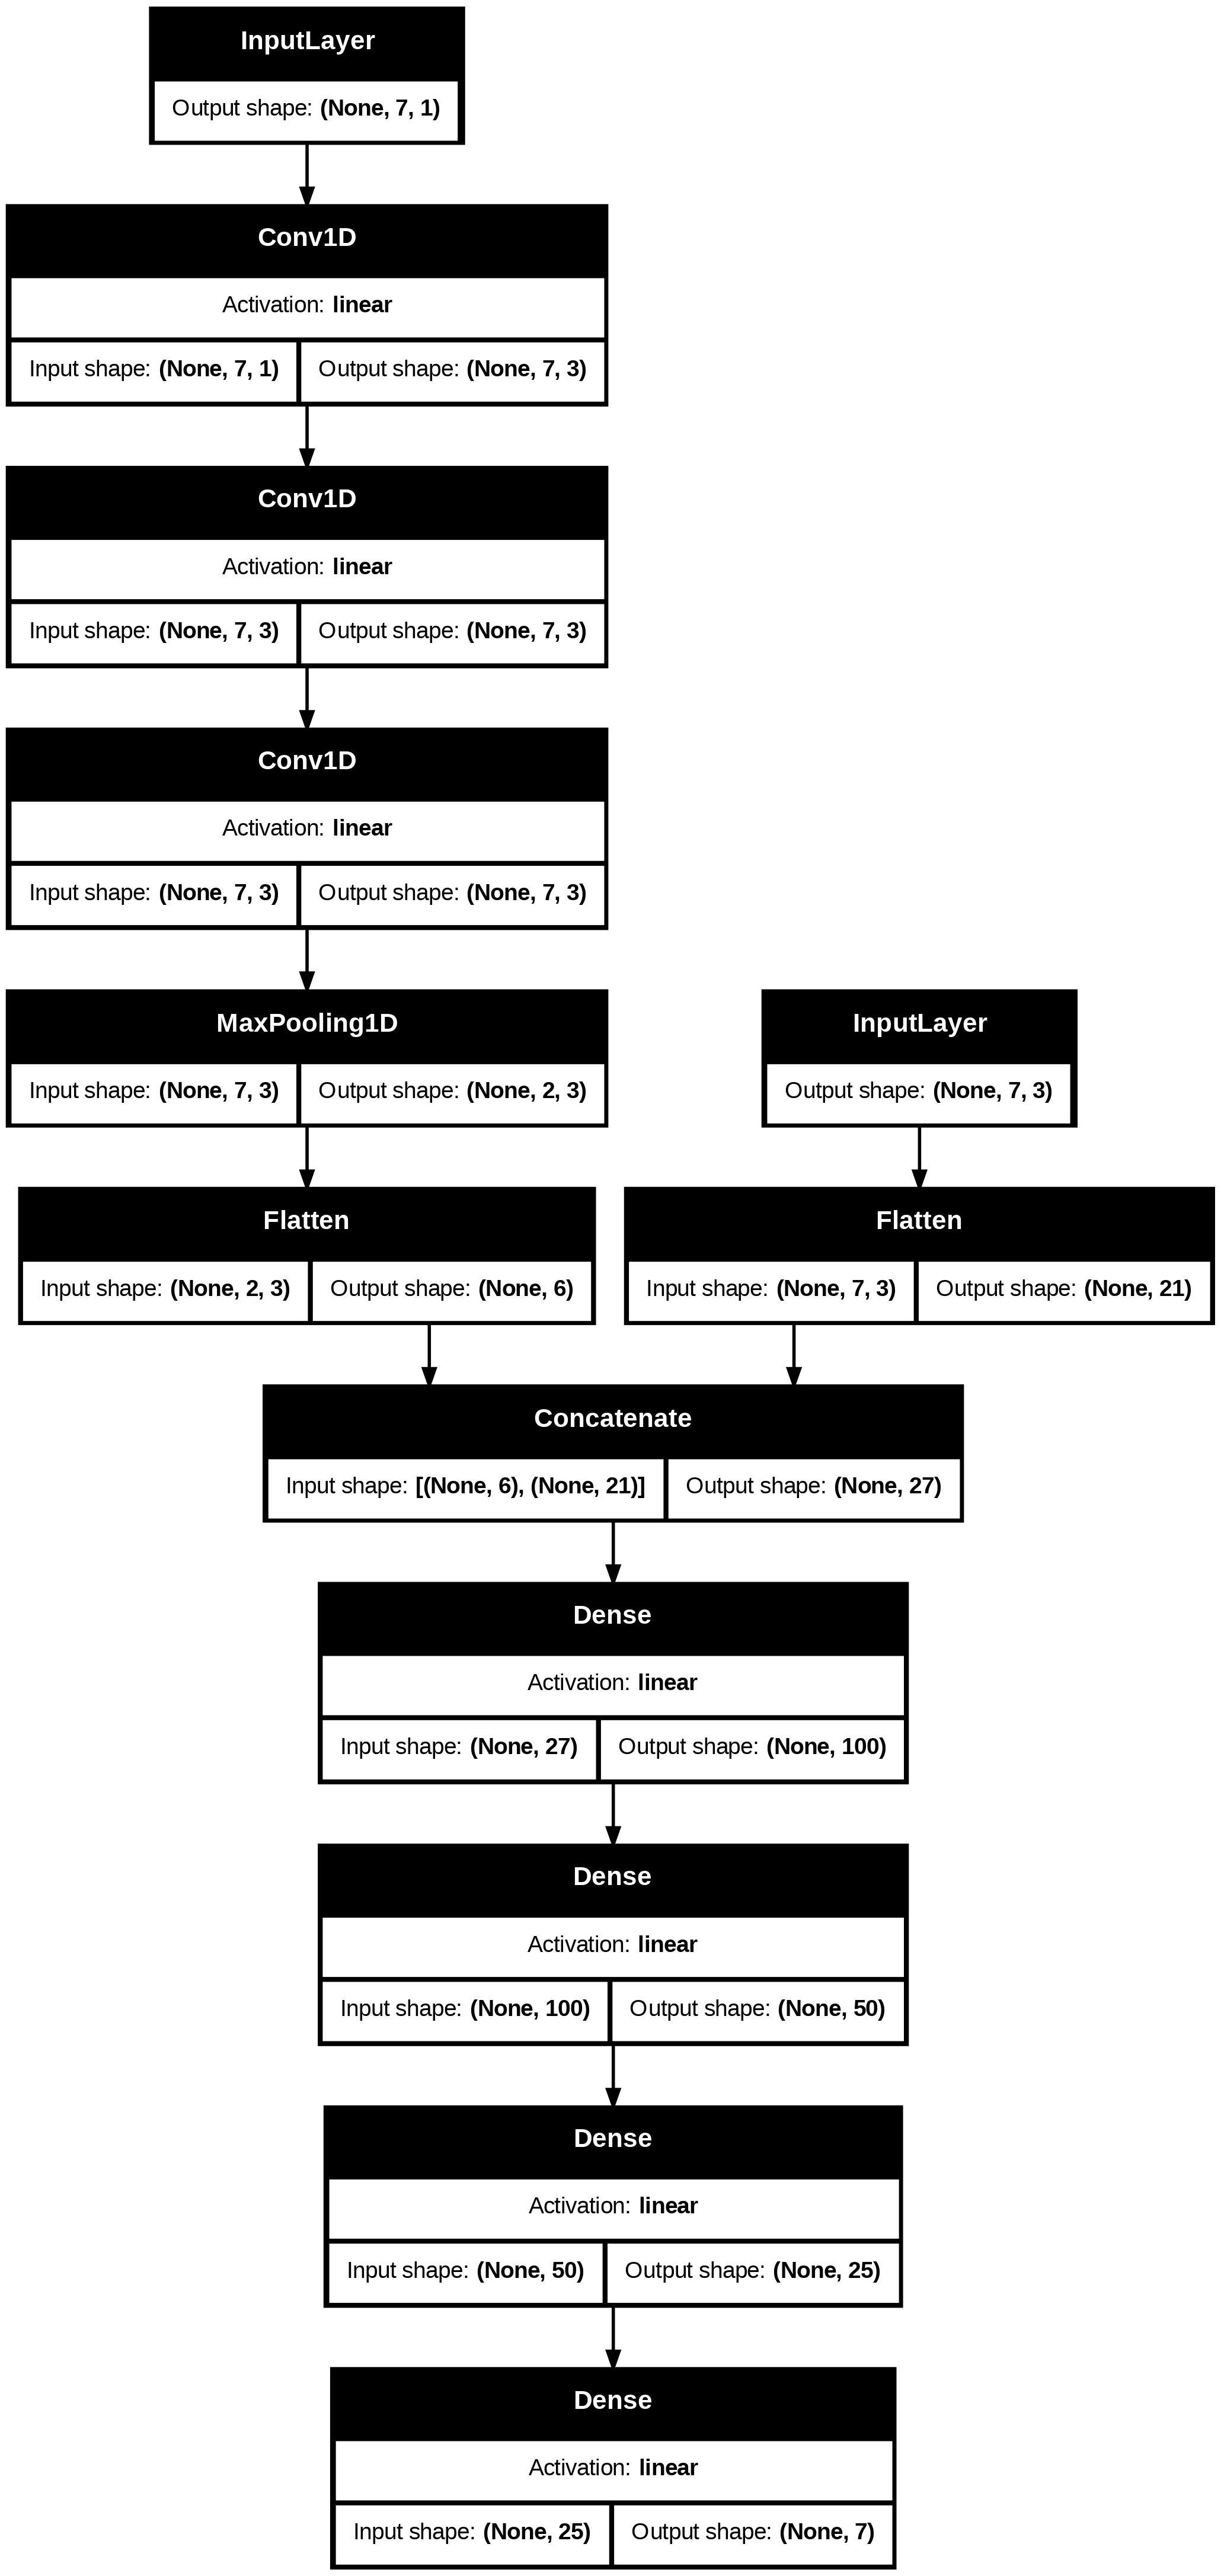

In [ ]:
plot_model(TCN_funct, to_file='functional TCN model.png', show_shapes=True, show_dtype=False, show_layer_names=False, show_layer_activations=True)

# **TCN Model evalution on training and validation set**

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


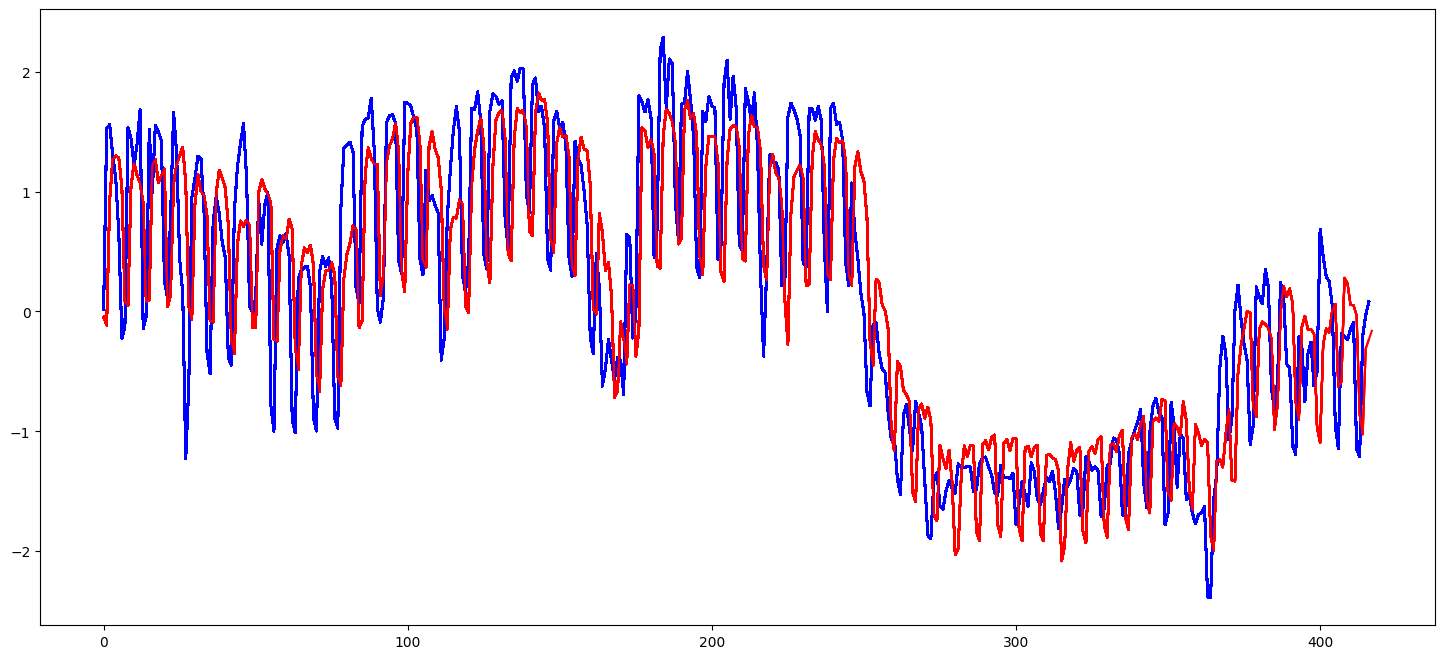

In [ ]:
# cell that plots averaged predictions
y_predict_train= TCN_funct.predict([X_ts_train, X_ft_train])
y_tren= y_train[7:-6,0,0]
plotted_days=y_train.shape[0]-6*2
y_pred=[]
for d in range(0,plotted_days):
  prediction = 0
  for i in [0,1,2,3,4,5,6]:
    prediction = prediction + y_predict_train[d+i,6-i]
  prediction = prediction/7
  y_pred.append(prediction)
  plt.figure(num=1, figsize=[18,8])
  plt.plot(y_tren,color="blue")
  plt.plot(y_pred,color="red")

# **Defined function used to measure multiple evaluation metrics**

In [ ]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)); mse = mean_squared_error(actual,forecast)
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax, 'mse':mse})

# **First Day prediction evaluation**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
{'mape': 0.02535284, 'me': -244.4885, 'mae': 12143.204, 'mpe': 0.0003961057, 'rmse': 16737.371836701244, 'corr': 0.7832469815013932, 'minmax': 0.02473902702331543, 'mse': 280139620.0}


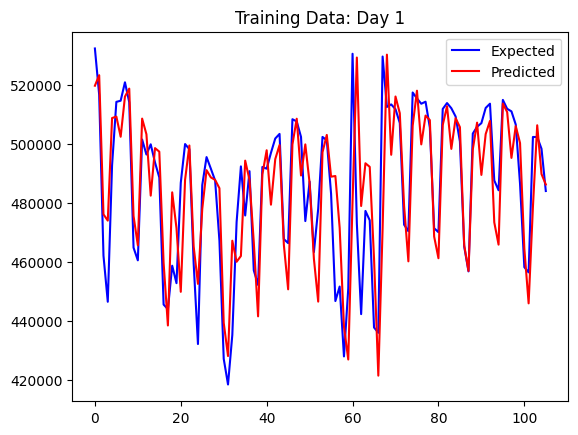

In [ ]:
y_predict_test = TCN_funct.predict([X_ts_val, X_ft_val])
y1 = []
y2 = []
for i in range(0,y_predict_test.shape[0]):
  y1.append(y_predict_test[i][0])
  y2.append(y_val[i][0])
forcast = np.array(y1)
actual = np.array(y2)
actual = actual.flatten()
forcast = forcast*std + mean ## Return data into the intial range before normalization
actual = actual*std + mean

plt.plot(actual,color="blue", label="Expected")
plt.plot(forcast,color="red", label="Predicted")
plt.legend(loc="upper right")
plt.title("Training Data: Day 1")

print(forecast_accuracy(forcast, actual))

# **7th Day prediction evaluation**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
{'mape': 0.033393104, 'me': 5092.638, 'mae': 15807.369, 'mpe': 0.011464862, 'rmse': 20135.632098347447, 'corr': 0.716881244763268, 'minmax': 0.03211253881454468, 'mse': 405443680.0}


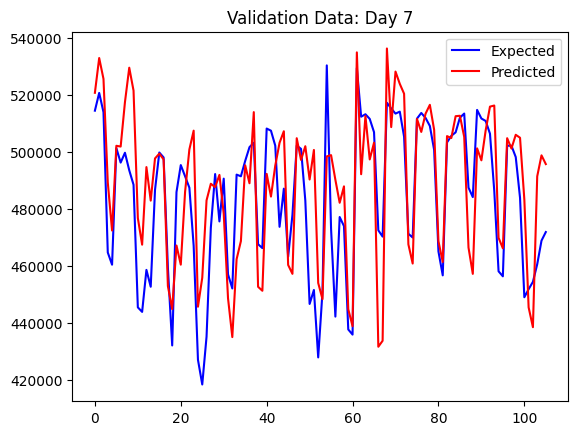

In [ ]:
y_predict_test = TCN_funct.predict([X_ts_val, X_ft_val])
y1 = []
y2 = []
for i in range(0,y_predict_test.shape[0]):
  y1.append(y_predict_test[i][6])
  y2.append(y_val[i][6])
forcast = np.array(y1)
actual = np.array(y2)
actual = actual.flatten()
forcast = forcast*std + mean ## Return data into the intial range before normalization
actual = actual*std + mean

plt.plot(actual,color="blue", label="Expected")
plt.plot(forcast,color="red", label="Predicted")
plt.legend(loc="upper right")
plt.title("Validation Data: Day 7")

print(forecast_accuracy(forcast, actual))

# **Total Average prediction evaluation**

In [ ]:
y_predict_test = TCN_funct.predict([X_ts_val, X_ft_val])
y1 = []
y2 = []
for i in range(0,y_predict_test.shape[0]):
  y1.append(y_predict_test[i].sum()/7)
  y2.append(y_val[i].sum()/7)
forcast = np.array(y1)
actual = np.array(y2)
actual = actual.flatten()
forcast = forcast*std + mean ## Return data into the intial range before normalization
actual = actual*std + mean

print(forecast_accuracy(forcast, actual))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
{'mape': 0.02132375509700571, 'me': 4229.303136752166, 'mae': 10255.327948372447, 'mpe': 0.009049365717239828, 'rmse': 13268.34393115689, 'corr': 0.588131820798656, 'minmax': 0.020813506262236325, 'mse': 176048950.67546788}


# **LSTM Model**

In [ ]:
n_inputs, n_channels, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
n_cells = 50
epochs =  300;
time_series = Input(shape=(n_inputs, 1))
other_feat = Input(shape=(n_inputs, n_channels-1))

conv1 = LSTM(n_cells, activation='linear', input_shape=(n_inputs,7), return_sequences=True)(time_series)
flat_ts = Flatten() (conv1)
flat_ft = Flatten() (other_feat)
merged = Concatenate(axis = 1) ([flat_ts, flat_ft])
dense_network = Dense(100, activation = 'linear')(merged)
dense_network = Dense(50, activation = 'linear')(dense_network)
dense_network = Dense(25, activation = 'linear')(dense_network)
output_ts = Dense(7, activation = 'linear') (dense_network)
LSTM_funct = Model(inputs = [time_series, other_feat], outputs = output_ts)
LSTM_funct.compile(optimizer = 'adam', loss = "mse")
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=100, verbose=2, mode='min')
LSTM_history = LSTM_funct.fit(x = [X_ts_train, X_ft_train], y = y_train, validation_data=[[X_ts_val,X_ft_val], y_val], epochs = epochs, batch_size = 10, callbacks=[monitor])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.9063 - val_loss: 0.1902
Epoch 2/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2712 - val_loss: 0.1571
Epoch 3/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2627 - val_loss: 0.2053
Epoch 4/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2255 - val_loss: 0.1435
Epoch 5/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2331 - val_loss: 0.1418
Epoch 6/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2072 - val_loss: 0.1429
Epoch 7/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2402 - val_loss: 0.1393
Epoch 8/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2328 - val_loss: 0.1448
Epoch 9/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2083 - val_loss: 0.1408
Epoch 10/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2269 - val_loss: 0.1421
Epoch 11/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2036 - val_loss: 0.1422
Epoch 12/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

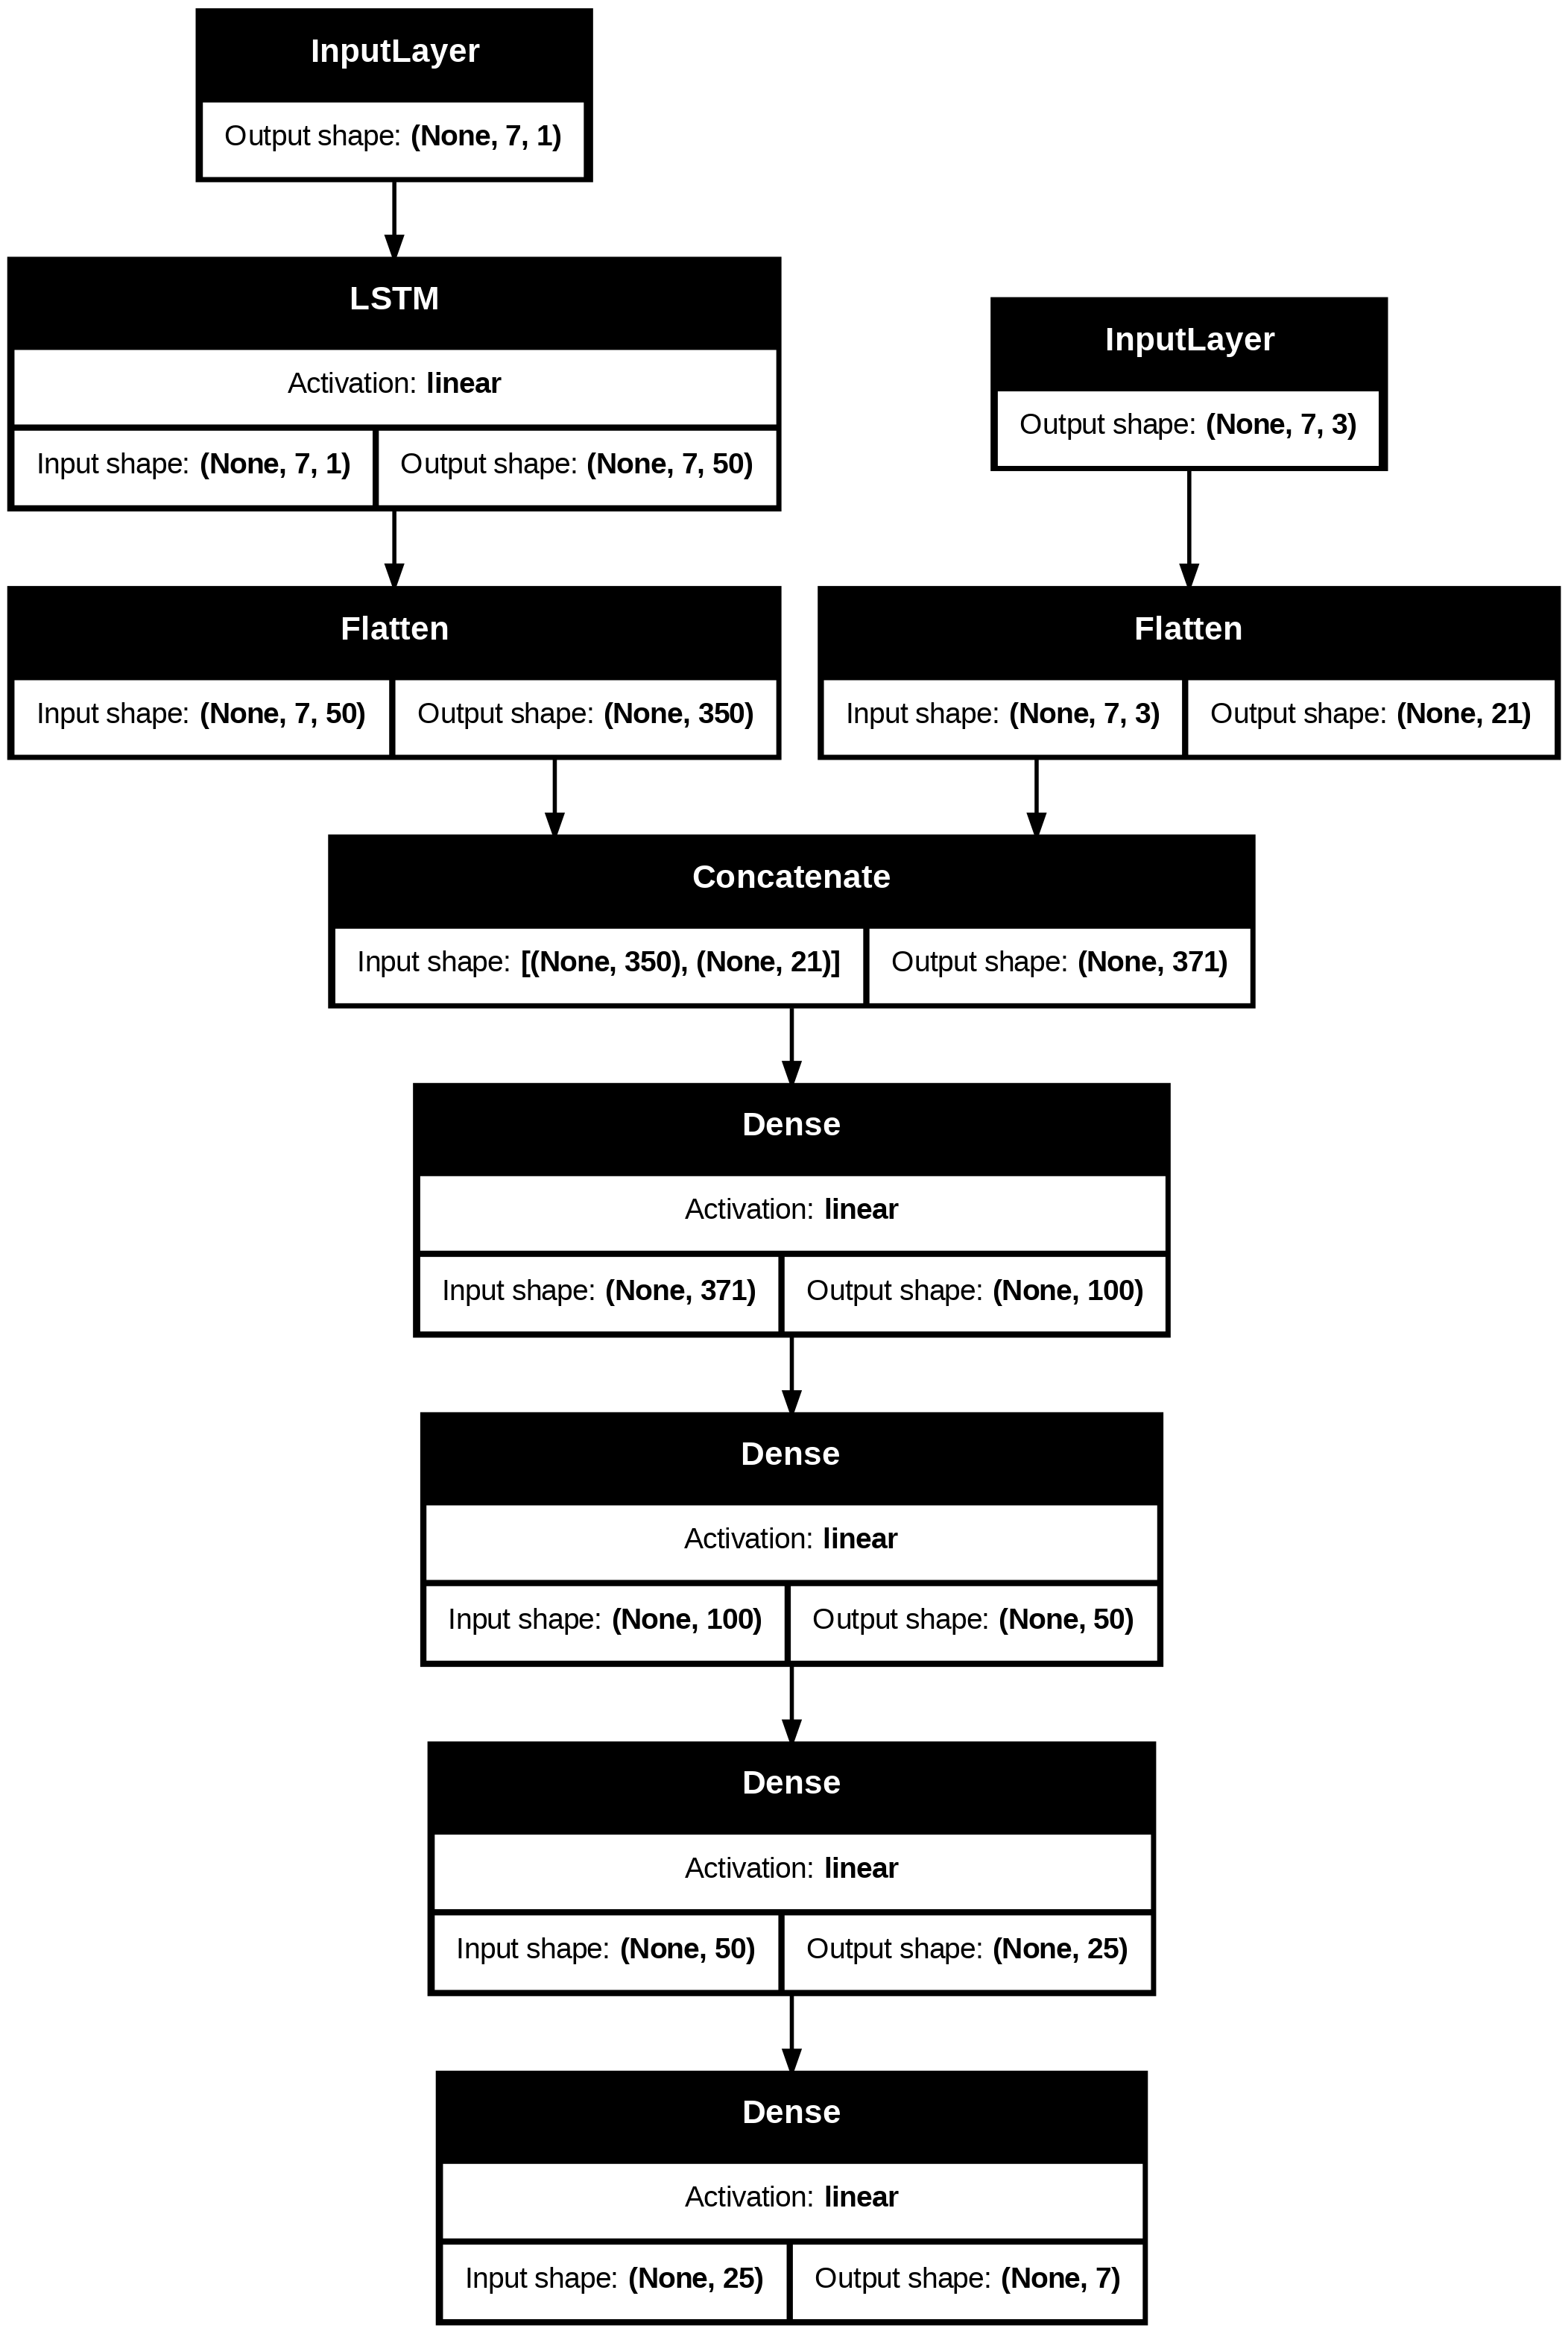

In [ ]:
plot_model(LSTM_funct, to_file='functional LSTM model.png', show_shapes=True, show_dtype=False, show_layer_names=False, show_layer_activations=True)

# **LSTM Model evalution on training and validation set**

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


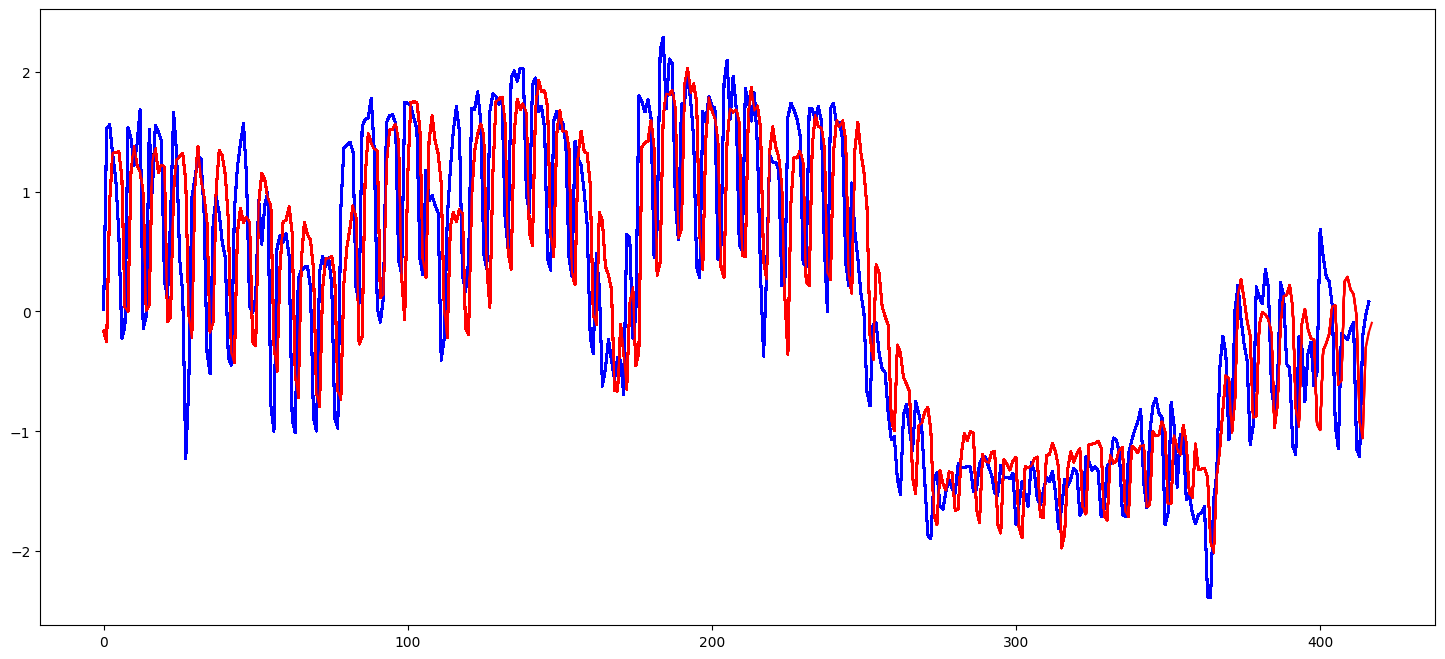

In [ ]:
# cell that plots averaged predictions
y_predict_train= LSTM_funct.predict([X_ts_train, X_ft_train])
y_tren= y_train[7:-6,0,0]
plotted_days=y_train.shape[0]-6*2
y_pred=[]
for d in range(0,plotted_days):
  #y_pred= y_predict_train[:,d]
  prediction = 0
  for i in [0,1,2,3,4,5,6]:
    prediction = prediction + y_predict_train[d+i,6-i]
  prediction = prediction/7
  y_pred.append(prediction)
  plt.figure(num=1, figsize=[18,8])
  plt.plot(y_tren,color="blue")
  plt.plot(y_pred,color="red")

# **First Day prediction evaluation**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
{'mape': 0.02459708, 'me': -1867.2361, 'mae': 11924.123, 'mpe': -0.0032544213, 'rmse': 16123.686923281535, 'corr': 0.8145625164542569, 'minmax': 0.02412998676300049, 'mse': 259973280.0}


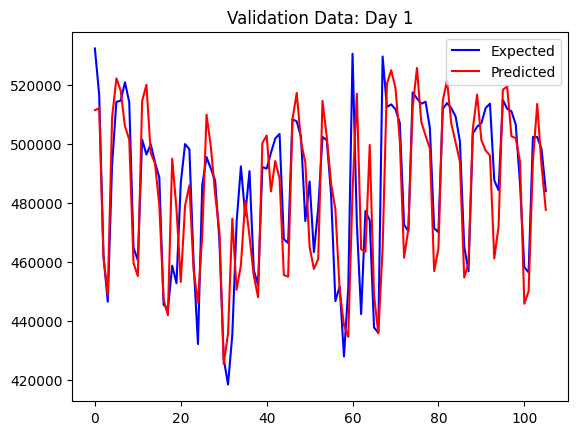

In [ ]:
y_predict_test = LSTM_funct.predict([X_ts_val, X_ft_val])
y1 = []
y2 = []
for i in range(0,y_predict_test.shape[0]):
  y1.append(y_predict_test[i][0])
  y2.append(y_val[i][0])
forcast = np.array(y1)
actual = np.array(y2)
actual = actual.flatten()
forcast = forcast*std + mean ## Return data into the intial range before normalization
actual = actual*std + mean

plt.plot(actual,color="blue", label="Expected")
plt.plot(forcast,color="red", label="Predicted")
plt.legend(loc="upper right")
plt.title("Validation Data: Day 1")

print(forecast_accuracy(forcast, actual))

# **7th Day prediction evaluation**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
{'mape': 0.0332511, 'me': 2877.2065, 'mae': 15738.175, 'mpe': 0.0072587538, 'rmse': 20064.440186558906, 'corr': 0.6734706689448199, 'minmax': 0.03205674886703491, 'mse': 402581760.0}


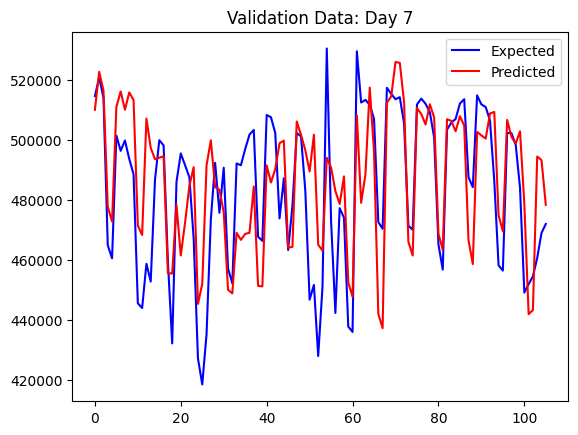

In [ ]:
y_predict_test = LSTM_funct.predict([X_ts_val, X_ft_val])
y1 = []
y2 = []
for i in range(0,y_predict_test.shape[0]):
  y1.append(y_predict_test[i][6])
  y2.append(y_val[i][6])
forcast = np.array(y1)
actual = np.array(y2)
actual = actual.flatten()
forcast = forcast*std + mean ## Return data into the intial range before normalization
actual = actual*std + mean

plt.plot(actual,color="blue", label="Expected")
plt.plot(forcast,color="red", label="Predicted")
plt.legend(loc="upper right")
plt.title("Validation Data: Day 7")

print(forecast_accuracy(forcast, actual))

# **Total Average prediction evaluation**

In [ ]:
y_predict_test = LSTM_funct.predict([X_ts_val, X_ft_val])
y1 = []
y2 = []
for i in range(0,y_predict_test.shape[0]):
  y1.append(y_predict_test[i].sum()/7)
  y2.append(y_val[i].sum()/7)
forcast = np.array(y1)
actual = np.array(y2)
actual = actual.flatten()
forcast = forcast*std + mean ## Return data into the intial range before normalization
actual = actual*std + mean

print(forecast_accuracy(forcast, actual))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
{'mape': 0.021801371567590086, 'me': 2439.209751314058, 'mae': 10480.999587898768, 'mpe': 0.005416768992464028, 'rmse': 13711.027264720777, 'corr': 0.5173312976454199, 'minmax': 0.021336662494752523, 'mse': 187992268.65391648}


# **Comparing all Models using Test set**

In [ ]:
X_ts_test = X_test[:,:,0]
X_ft_test = X_test[:,:,1:]
y_predict_test = TCN_funct.predict([X_ts_test, X_ft_test])
y1 = []
y2 = []
for i in range(0,y_predict_test.shape[0]):
  y1.append(y_predict_test[i].sum()/7)
  y2.append(y_test[i].sum()/7)

forcast = np.array(y1)
actual = np.array(y2)
actual = actual.flatten()
forcast = forcast*std + mean
actual = actual*std + mean


print(forecast_accuracy(forcast, actual))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
{'mape': 0.026262452155617018, 'me': -2482.7535475330474, 'mae': 12980.856516693126, 'mpe': -0.0042601908768410465, 'rmse': 17666.761727474866, 'corr': 0.6773074019789829, 'minmax': 0.025680322519112897, 'mse': 312114469.9353707}


In [ ]:
y_predict_test = LSTM_funct.predict([X_ts_test, X_ft_test])
y1 = []
y2 = []
for i in range(0,y_predict_test.shape[0]):
  y1.append(y_predict_test[i].sum()/7)
  y2.append(y_test[i].sum()/7)

forcast = np.array(y1)
actual = np.array(y2)
actual = actual.flatten()
forcast = forcast*std + mean
actual = actual*std + mean

print(forecast_accuracy(forcast, actual))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
{'mape': 0.02722015915056189, 'me': -1346.9575743083758, 'mae': 13404.664641074387, 'mpe': -0.0019406392260482932, 'rmse': 17992.59281915022, 'corr': 0.6641589962515979, 'minmax': 0.02658857302397133, 'mse': 323733396.3557361}
